# Big Data Project Anna & Janika

Creating Spark session and loading the dataset

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnull
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType

spark = SparkSession.builder.appName("SteamGamesSuccess").getOrCreate()

data = "games_march2025_full.csv"
df = spark.read.csv("games_march2025_full.csv", header=True, inferSchema=True)
df.show(truncate=False)

+-------+-------------------------------+------------+------------+-----+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Declaring the columns that we will be using

In [2]:
used_columns = [
    "appid", "name", "release_date", "genres", "tags", "developers", "publishers",
    "price", "discount", "recommendations", "positive", "negative", "peak_ccu", "dlc_count"
]

df1 = df.select(*used_columns)

df1.show(20)

+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+--------+---------------+--------+--------+--------+---------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount|recommendations|positive|negative|peak_ccu|dlc_count|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+--------+---------------+--------+--------+--------+---------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|           ['Valve']|    0|       0|        4401572| 7480813| 1135108| 1212356|        1|
| 578080| PUBG: BATTLEGROUNDS|  21/12/2017|['Action', 'Adven...|{'Survival': 1483...|['PUBG Corporation']|   ['KRAFTON, Inc.']|    0|       0|        1732007| 1487960| 1024436|  616738|        0|
|    570|           

Renaming some the unclear named columns

In [3]:
df1 = df1.withColumnRenamed("discount", "discount_percentage")

In [4]:
df1 = df1.withColumnRenamed("peak_ccu", "peak_playernum")

Displaying the structure of our data

In [5]:
df1.printSchema()

root
 |-- appid: string (nullable = true)
 |-- name: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- developers: string (nullable = true)
 |-- publishers: string (nullable = true)
 |-- price: string (nullable = true)
 |-- discount_percentage: string (nullable = true)
 |-- recommendations: string (nullable = true)
 |-- positive: string (nullable = true)
 |-- negative: string (nullable = true)
 |-- peak_playernum: string (nullable = true)
 |-- dlc_count: string (nullable = true)



Showing the total records and sample of the data

In [6]:
print(f"Total Records: {df1.count()}")

df1.show()

Total Records: 94954
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|           ['Valve']|    0|                  0|        4401572| 7480813| 1135108|       1212356|        1|
| 578080| PUBG: BATTLEGROUNDS|  21/12/2017|['Action', 'Adven...|{'Survival': 1483...|['PUBG Corporation']|   ['KRAFTON, Inc.']|

# Data Preprocessing


Calculating the amount and handling Missing Values

In [7]:
from pyspark.sql.functions import col, sum

null_counts = df1.select([sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns])
null_counts.show()

+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+
|appid|name|release_date|genres|tags|developers|publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|
+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+
|    0|   2|           0|     5|  10|         9|         9|    0|                 11|             10|     110|      75|             9|        0|
+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+



- We dropped null name rows, because a game without a name is invalid. 
- We dropped null tag rows, because there were quite a few of them and we do not get much out of them.
- We dropped null peak_playernum rows, because if it has had no peak it means it it does not have a playerbase, so we do not need it.

In [8]:
df_cleaned = df1.dropna(subset=["name", "tags", "peak_playernum"])

We changed null string values into "unknown", and int values into 0 where we thought its necessary

In [9]:
df_filled = df_cleaned.fillna({"genres": "unknown", "developers": "unknown", "publishers": "unknown", "discount_percentage": "0", "recommendations": "0"
                               ,"positive": "0", "negative": "0"})

Imported some more spark functions

In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, regexp_replace, trim, when, round

We cleaned and created new positive and negative amount of reviews columns, as well as calculated the all reviews. This was necessary due to the data being inconsistent in the original dataset, which made the existing data unreliable for analysis.

In [11]:
df = df_filled.withColumn(
    "positive_clean",
    when(
        trim(col("positive")).rlike("^\d+$"),
        trim(col("positive")).cast("double")
    ).otherwise(0)
).withColumn(
    "negative_clean",
    when(
        trim(col("negative")).rlike("^\d+$"),
        trim(col("negative")).cast("double")
    ).otherwise(0)
).withColumn(
    "all_reviews",
    round(col("positive_clean") + col("negative_clean"), 2)
)


Created the percentage of positive and negative reviews column

In [12]:
df_with_percentages = df.withColumn(
    "positive_percentage", 
    (F.col("positive") / F.col("all_reviews") * 100).cast("double")
).withColumn(
    "negative_percentage", 
    (F.col("negative") / F.col("all_reviews") * 100).cast("double")
)

df_with_percentages = df_with_percentages.withColumn(
    "positive_percentage", 
    F.round(F.col("positive_percentage"), 2)
).withColumn(
    "negative_percentage", 
    F.round(F.col("negative_percentage"), 2)
)

df_with_percentages.show()


+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|positive_clean|negative_clean|all_reviews|positive_percentage|negative_percentage|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|         

Handled the missing data in newly created columns

In [13]:
df = df_with_percentages.fillna({"positive_percentage": "0", "negative_percentage": "0"})

In [14]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|appid|name|release_date|genres|tags|developers|publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|positive_clean|negative_clean|all_reviews|positive_percentage|negative_percentage|
+-----+----+------------+------+----+----------+----------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|    0|   0|           0|     0|   0|         0|         0|    0|                  0|              0|       0|       0|             0|        0|             0|             0|          0|                  0|                  0|
+-----+----+------------+------+----+----------+----------+-----+-------------------+-------

In [15]:
df.show()

+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|  appid|                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|positive|negative|peak_playernum|dlc_count|positive_clean|negative_clean|all_reviews|positive_percentage|negative_percentage|
+-------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------+--------+--------------+---------+--------------+--------------+-----------+-------------------+-------------------+
|    730|    Counter-Strike 2|  21/08/2012|['Action', 'Free ...|{'FPS': 90857, 'S...|           ['Valve']|         

Handling the duplicates in the data (in columns appid and name)

In [16]:
id_duplicates = df.groupBy("appid").count().filter("count > 1")
name_duplicates = df.groupBy("name").count().filter("count > 1")

id_duplicates.show()
name_duplicates.show()

+--------------------+-----+
|               appid|count|
+--------------------+-----+
|nd deciding the s...|    2|
|   ahead of schedule|    2|
+--------------------+-----+

+--------------------+-----+
|                name|count|
+--------------------+-----+
|      Eternal Return|    2|
|               Nomad|    2|
|Loading Screen Si...|    2|
|The Lord of the R...|    2|
|             Journey|    2|
|Call of Duty®: Bl...|    2|
|        Blood Strike|    2|
|Call of Duty®: Bl...|    2|
|    EA SPORTS FC™ 24|    4|
|              ISLAND|    2|
|Romance of the Th...|    2|
|            Downfall|    2|
|     torpedo strikes|    2|
|                Home|    2|
|Ys I & II Chronic...|    2|
| Monday Night Combat|    2|
|               Chasm|    2|
|       Second Chance|    2|
|      Hero's Journey|    3|
|          The Bunker|    3|
+--------------------+-----+
only showing top 20 rows



In [17]:
df_no_duplicates = df.dropDuplicates(["name"])

name_duplicates = df_no_duplicates.groupBy("name").count().filter("count > 1")
name_duplicates.show()

+----+-----+
|name|count|
+----+-----+
+----+-----+



In [18]:
used_columns = [
    "appid", "name", "release_date", "genres", "tags", "developers", "publishers",
    "price", "discount_percentage", "recommendations", "peak_playernum", "dlc_count", "all_reviews", "positive_percentage", "negative_percentage"
]

df_final = df_no_duplicates.select(*used_columns)

Showing the final, cleaned data

In [19]:
df_final.show(10)

+-------+------------------------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------------+---------+-----------+-------------------+-------------------+
|  appid|                                name|release_date|              genres|                tags|          developers|          publishers|price|discount_percentage|recommendations|peak_playernum|dlc_count|all_reviews|positive_percentage|negative_percentage|
+-------+------------------------------------+------------+--------------------+--------------------+--------------------+--------------------+-----+-------------------+---------------+--------------+---------+-----------+-------------------+-------------------+
|3066390|"軍艦島探訪記　ある写真家の記録　...|  01/08/2024|      ['Simulation']|{'Simulation': 53...|         ['XYimage']|         ['XYimage']|19.99|                  0|              0|             0|        0|        4.0|     

# MongoDB

Converting the dataFrame to Pandas and MongoDB docs and inserting it to mongoDB as 'games_cleaned'. We also replaced the _id column created by MongoDB with our appid column for better readability

In [20]:
pandas_df = df_final.toPandas()

records = pandas_df.to_dict(orient="records")

for doc in records:
    doc["_id"] = doc["appid"]  

from pymongo import MongoClient
client = MongoClient("mongodb://localhost:27017/")
db = client["steam_games_db"]
collection = db["games_cleaned"]

collection.drop()

collection.insert_many(records)

print(f"Inserted {len(records)} docs")

Inserted 94178 docs


Loading the data back from MongoDB into spark DataFrame and reordering the column order so the appid is first

In [21]:
games_docs = list(db["games_cleaned"].find({}, {"_id": 0})) 

df_games = spark.createDataFrame(games_docs)

columns = ['appid'] + [col for col in df_games.columns if col != 'appid']

df_games = df_games.select(*columns)

df_games.show(3)

+-------+-----------+--------------------+-------------------+---------+-------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|             genres|                                name|negative_percentage|peak_playernum|positive_percentage|price|          publishers|recommendations|release_date|                tags|
+-------+-----------+--------------------+-------------------+---------+-------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+
|3066390|        4.0|         ['XYimage']|                  0|        0|     ['Simulation']|"軍艦島探訪記　ある写真家の記録　...|               25.0|             0|               75.0|19.99|         ['XYimage']|              0|  0

# Spark optimization


 Cache the DataFrame because it will be used multiple times

In [22]:
df_games.cache()

DataFrame[appid: string, all_reviews: double, developers: string, discount_percentage: string, dlc_count: string, genres: string, name: string, negative_percentage: double, peak_playernum: string, positive_percentage: double, price: string, publishers: string, recommendations: string, release_date: string, tags: string]

Showing the execution plan to check optimizations

The plan shows how Spark reads our data, selects the needed columns and optimizes the process by caching it in memory

In [23]:
df_games.explain(True)

== Parsed Logical Plan ==
'Project ['appid, 'all_reviews, 'developers, 'discount_percentage, 'dlc_count, 'genres, 'name, 'negative_percentage, 'peak_playernum, 'positive_percentage, 'price, 'publishers, 'recommendations, 'release_date, 'tags]
+- LogicalRDD [all_reviews#7653, appid#7654, developers#7655, discount_percentage#7656, dlc_count#7657, genres#7658, name#7659, negative_percentage#7660, peak_playernum#7661, positive_percentage#7662, price#7663, publishers#7664, recommendations#7665, release_date#7666, tags#7667], false

== Analyzed Logical Plan ==
appid: string, all_reviews: double, developers: string, discount_percentage: string, dlc_count: string, genres: string, name: string, negative_percentage: double, peak_playernum: string, positive_percentage: double, price: string, publishers: string, recommendations: string, release_date: string, tags: string
Project [appid#7654, all_reviews#7653, developers#7655, discount_percentage#7656, dlc_count#7657, genres#7658, name#7659, negati

Defining an UDF to classify games based on positive_percentage and recommendations and applying the UDF to add a new column 'success_category' based on the classification.

In [24]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col

def classify_success(positive_percentage, recommendations):
    try:
        recommendations_int = int(recommendations) 
    except ValueError:
        recommendations_int = 0  

    if positive_percentage > 80 and recommendations_int > 1000:
        return "Successful"
    elif positive_percentage > 50 and recommendations_int > 100:
        return "Moderate"
    else:
        return "Unsuccessful"

classify_success_udf = udf(classify_success, StringType())

games_with_success_classification = df_games.withColumn(
    "success_category", 
    classify_success_udf(col("positive_percentage"), col("recommendations"))
)

games_with_success_classification.show()


+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|              genres|                                name|negative_percentage|peak_playernum|positive_percentage|price|          publishers|recommendations|release_date|                tags|success_category|
+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|3066390|        4.0|         ['XYimage']|                  0|        0|      ['Simulation']|"軍艦島探訪記　ある写真家の記録　...|               25.0|             0|           

We are creating a temporary view of our data

In [25]:
games_with_success_classification.createOrReplaceTempView("games")

In [26]:
spark.sql("SELECT * FROM games").show(10)

+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|              genres|                                name|negative_percentage|peak_playernum|positive_percentage|price|          publishers|recommendations|release_date|                tags|success_category|
+-------+-----------+--------------------+-------------------+---------+--------------------+------------------------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|3066390|        4.0|         ['XYimage']|                  0|        0|      ['Simulation']|"軍艦島探訪記　ある写真家の記録　...|               25.0|             0|           

Showing the data with filters applied

In [27]:
spark.sql("SELECT * FROM games WHERE success_category NOT LIKE 'Unsuccessful'").show()

+-------+-----------+--------------------+-------------------+---------+--------------------+--------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|  appid|all_reviews|          developers|discount_percentage|dlc_count|              genres|                name|negative_percentage|peak_playernum|positive_percentage|price|          publishers|recommendations|release_date|                tags|success_category|
+-------+-----------+--------------------+-------------------+---------+--------------------+--------------------+-------------------+--------------+-------------------+-----+--------------------+---------------+------------+--------------------+----------------+
|1864790|      226.0|      ['1BITDRAGON']|                  0|        0|['Audio Productio...|          1BITDRAGON|               3.98|             1|              96.02|29.99|      ['1BITDRAGON']|            

Filtering out rows with 'Unsuccessful' success_category because we're intrested in succesfull and moderate games

In [28]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

filtered_df = games_with_success_classification.filter(F.col("success_category") != "Unsuccessful")

## Comparing the overall success of the games in 2025

Categorizing prices

In [29]:
categorized_df = filtered_df.withColumn(
    "price_category",
    F.when(F.col("price") == 0, "Free")
     .when(F.col("price") < 10, "Budget")
     .when(F.col("price") < 30, "Mid-range")
     .otherwise("Premium")
)

Categorizing the success 

In [30]:
success_order = F.when(F.col("success_category") == "Successful", 3) \
                 .when(F.col("success_category") == "Moderate", 2) \
                 .when(F.col("success_category") == "Unsuccessful", 1) \
                 .otherwise(0)


Adding a numerical success rank to the DataFrame, then using a window function to rank games within each price category based on how successful they are (success_order function from above)

Then also we did a performance evaluation and checked how long this window function took to execute.

In [31]:
import time

categorized_df = categorized_df.withColumn("success_rank", success_order)

price_window = Window.partitionBy("price_category").orderBy(F.desc("success_rank"))

start_time = time.time()
price_analysis = categorized_df.withColumn("rank_in_category", F.rank().over(price_window))
price_analysis.select("appid","name", "price", "price_category", "success_category", "success_rank", "rank_in_category").show(truncate=False)
print(f"Window function execution time: {time.time() - start_time:.2f} seconds")


+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|appid  |name                                          |price|price_category|success_category|success_rank|rank_in_category|
+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|1424660|9-nine-:Episode 4                             |9.99 |Budget        |Successful      |3           |1               |
|397270 |A Kiss For The Petals - Remembering How We Met|7.99 |Budget        |Successful      |3           |1               |
|948740 |AI: The Somnium Files                         |7.99 |Budget        |Successful      |3           |1               |
|317250 |Airscape - The Fall of Gravity                |4.99 |Budget        |Successful      |3           |1               |
|571880 |Angels with Scaly Wings™ / 鱗羽の天使         |9.99 |Budget        |Successful      |3           |1               |
|2763

Counting each success category game amount and doing a performance evaluation.

In [32]:
success_categories = ["Successful", "Moderate", "Unsuccessful"]
counts = []
start_time = time.time()
for category in success_categories:
    count = games_with_success_classification.filter(
        col("success_category") == category
    ).count()

    print(f"{category}: {count} games")
    counts.append(count)

print(f"Count execution time: {time.time() - start_time:.2f} seconds")

Successful: 3585 games
Moderate: 11455 games
Unsuccessful: 79138 games
Count execution time: 53.42 seconds


Showing and creating new dataframe with only successful and moderate games

In [34]:
best_games = price_analysis.filter(F.col("rank_in_category") != "3")
best_games.select("appid", "name", "price", "price_category", "success_category", "success_rank", "rank_in_category").show(truncate=False)

+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|appid  |name                                          |price|price_category|success_category|success_rank|rank_in_category|
+-------+----------------------------------------------+-----+--------------+----------------+------------+----------------+
|1424660|9-nine-:Episode 4                             |9.99 |Budget        |Successful      |3           |1               |
|397270 |A Kiss For The Petals - Remembering How We Met|7.99 |Budget        |Successful      |3           |1               |
|948740 |AI: The Somnium Files                         |7.99 |Budget        |Successful      |3           |1               |
|317250 |Airscape - The Fall of Gravity                |4.99 |Budget        |Successful      |3           |1               |
|571880 |Angels with Scaly Wings™ / 鱗羽の天使         |9.99 |Budget        |Successful      |3           |1               |
|2763

Converting the dataFrame to Pandas and MongoDB docs and inserting it to mongoDB as 'successful_games'. We also replaced the _id column created by MongoDB with our appid column for better readability.

In [35]:
best_games_pandas = best_games.select(
    "appid", "name", "price", "price_category", "success_category", "success_rank", "rank_in_category"
).toPandas()

records = best_games_pandas.to_dict(orient="records")

In [36]:
for doc in records:
    doc["_id"] = doc["appid"] 
    

collection = db["successful_games"]
collection.insert_many(records)

InsertManyResult(['1424660', '397270', '948740', '317250', '571880', '2763670', '55040', '200910', '622650', '1942280', '2835570', '302080', '2055050', '527450', '599750', '1292940', '743390', '1266690', '25800', '347830', '511470', '1053680', '209080', '259550', '1866180', '913550', '324680', '1839880', '1801650', '483980', '1267910', '64000', '296470', '1451940', '858210', '235320', '798840', '390520', '461620', '282440', '1187510', '364420', '825630', '1955330', '475190', '204340', '1025250', '1892420', '1340480', '39680', '2190290', '228760', '260230', '431960', '2726450', '2212330', '1211600', '952290', '499440', '282800', '342580', '578850', '2704110', '537110', '320430', '1218280', '208650', '1634150', '1968730', '1257410', '405290', '736190', '208200', '447820', '248330', '364390', '2015240', '431590', '298110', '1353270', '947300', '341940', '1999170', '2196790', '593960', '1160490', '743130', '356190', '855640', '252670', '2237970', '865540', '39530', '1951230', '688130', '15

We count the amount of moderate and succesful games in total

In [37]:
best_games.count()

15040

We analyzed which tags are most common in successful vs moderate games. 
- Exploded the tags column to turn each tag into a separate row.
- Cleaned the tags by removing extra characters and numbers after colons.
- Counted how often each tag appears in successful and moderate games separately.
- Joined both counts on the tag name to compare them.
- Sorted the final results by how often each tag appears in successful games.
- Measured the execution time for performance insights.


In [38]:
from pyspark.sql.functions import explode, split, regexp_replace, col
start_time = time.time()

best_games = price_analysis.filter(F.col("rank_in_category") != "3")

df_exploded_tags = best_games.withColumn(
    "tag", 
    explode(split(regexp_replace("tags", "[\\[\\]' ]", ""), ","))
)

df_exploded_tags_clean = df_exploded_tags.withColumn(
    "clean_tag", 
    split(col("tag"), ":").getItem(0)
)


In [39]:
df_successful = df_exploded_tags_clean.filter(col("success_category") == "Successful") \
    .groupBy("clean_tag").count().withColumnRenamed("count", "successful_count")

df_moderate = df_exploded_tags_clean.filter(col("success_category") == "Moderate") \
    .groupBy("clean_tag").count().withColumnRenamed("count", "moderate_count")

df_joined = df_successful.join(
    df_moderate,
    on="clean_tag",
    how="outer"
)
df_exploded_tags_clean.cache()  
df_successful.cache()           
df_moderate.cache()             

df_joined_ordered = df_joined.orderBy("successful_count", ascending=False)

print(f"Count execution time: {time.time() - start_time:.2f} seconds")

Count execution time: 1.92 seconds


In [40]:
df_joined_ordered.limit(20).show()

+---------------+----------------+--------------+
|      clean_tag|successful_count|moderate_count|
+---------------+----------------+--------------+
|   Singleplayer|            2758|          7050|
|      Adventure|            1725|          4217|
|          Indie|            1674|          5353|
|         Action|            1552|          3627|
|    Atmospheric|            1228|          2694|
|      StoryRich|            1211|          2631|
|             2D|            1098|          3201|
|    Multiplayer|            1058|          2099|
|         Casual|             982|          3286|
|GreatSoundtrack|             932|          1229|
|     Simulation|             889|          2435|
|            RPG|             850|          2270|
|       Strategy|             770|          2116|
|          Funny|             770|          1541|
|    Exploration|             739|          1872|
|   First-Person|             726|          1860|
|      OpenWorld|             690|          1301|


Converting the dataFrame to Pandas and MongoDB docs and inserting it to mongoDB as 'most_used_tags'. We also replaced the _id column created by MongoDB with our appid column for better readability.

In [41]:
most_used_tags_df = df_joined_ordered.toPandas()

records = most_used_tags_df.to_dict(orient="records")

collection = db["most_used_tags"]

collection.drop()

collection.insert_many(records)

print(f"Inserted {len(records)} documents into 'most_used_tags' collection.")


Inserted 964 documents into 'most_used_tags' collection.


Importing the collection back for visualization purposes

In [42]:
import pandas as pd
most_used_tags_docs = list(db["most_used_tags"].find())

most_used_tags_df = pd.DataFrame(most_used_tags_docs)

print(most_used_tags_df.head())


                        _id     clean_tag  successful_count  moderate_count
0  67f65a178905de817a4871a1  Singleplayer            2758.0          7050.0
1  67f65a178905de817a4871a2     Adventure            1725.0          4217.0
2  67f65a178905de817a4871a3         Indie            1674.0          5353.0
3  67f65a178905de817a4871a4        Action            1552.0          3627.0
4  67f65a178905de817a4871a5   Atmospheric            1228.0          2694.0


# Visualization

Visualizing the most intresting findings

1. Top 20 Most used tags in succesful games using seaborn

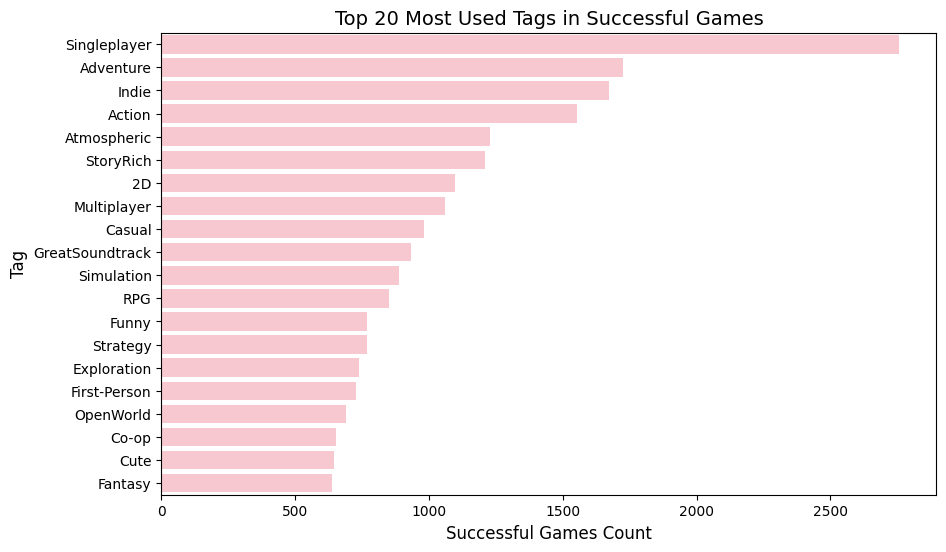

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

most_used_tags_df = most_used_tags_df.sort_values(by="successful_count", ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x="successful_count", y="clean_tag", data=most_used_tags_df.head(20), color="pink")

plt.title("Top 20 Most Used Tags in Successful Games", fontsize=14)
plt.xlabel("Successful Games Count", fontsize=12)
plt.ylabel("Tag", fontsize=12)

plt.show()


2. Pie chart out of success categories in games

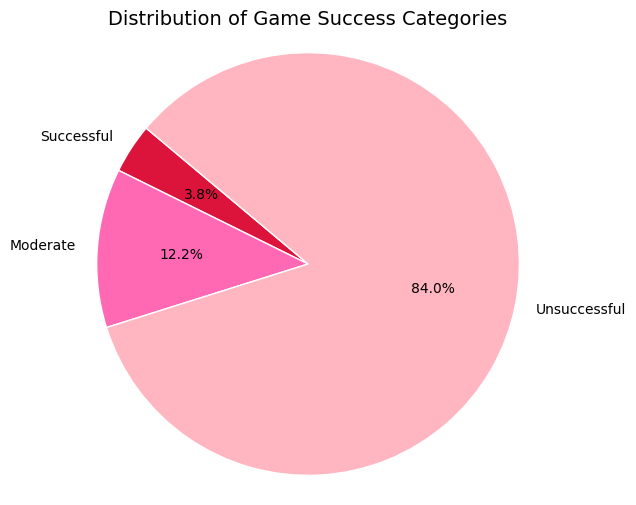

In [45]:
plt.figure(figsize=(6, 6))
colors = ["crimson", "hotpink", "lightpink"]
plt.pie(
    counts,
    labels=success_categories,
    colors=colors,
    autopct="%1.1f%%",
    startangle=140,
    wedgeprops={"edgecolor": "white"}
)
plt.title("Distribution of Game Success Categories", fontsize=14)
plt.axis("equal") 
plt.show()

Importing the 'successful_games_data' collection back for visualization purposes

In [54]:
import pandas as pd
collection = db["successful_games"]
successful_games = collection.find({}, {"_id": 0}) 

successful_games_df = pd.DataFrame(list(successful_games))

print(successful_games_df.head())

     appid                                            name price  \
0  1424660                               9-nine-:Episode 4  9.99   
1   397270  A Kiss For The Petals - Remembering How We Met  7.99   
2   948740                           AI: The Somnium Files  7.99   
3   317250                  Airscape - The Fall of Gravity  4.99   
4   571880                Angels with Scaly Wings™ / 鱗羽の天使  9.99   

  price_category success_category  success_rank  rank_in_category  
0         Budget       Successful             3                 1  
1         Budget       Successful             3                 1  
2         Budget       Successful             3                 1  
3         Budget       Successful             3                 1  
4         Budget       Successful             3                 1  


3. Count of successful and moderate games by price category on a chart

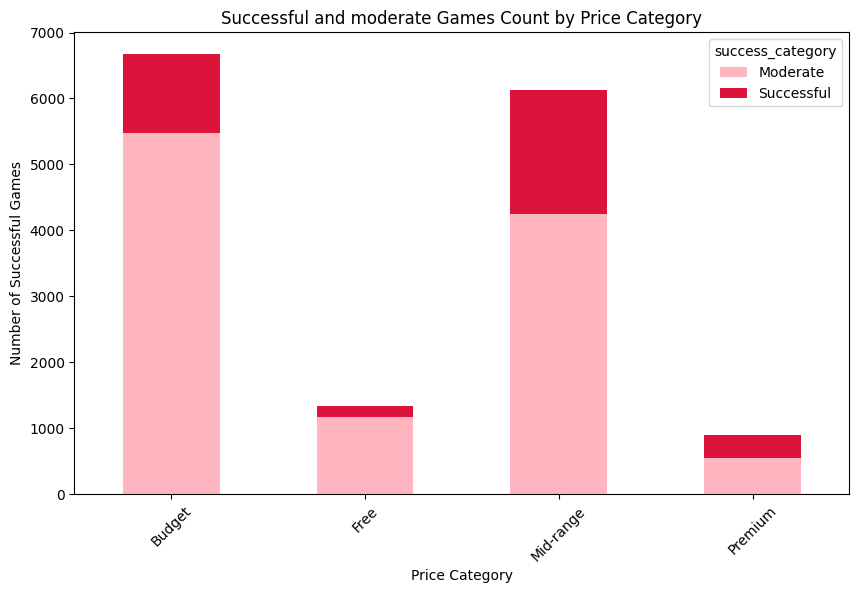

In [58]:
success_by_price = successful_games_df.groupby('price_category')['success_category'].value_counts().unstack().fillna(0)

success_by_price.plot(kind='bar', stacked=True, color=['lightpink', 'crimson'], figsize=(10, 6))
plt.title('Successful and moderate Games Count by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Number of Successful Games')
plt.xticks(rotation=45)
plt.show()

4. Successful tags in each game category on a chart

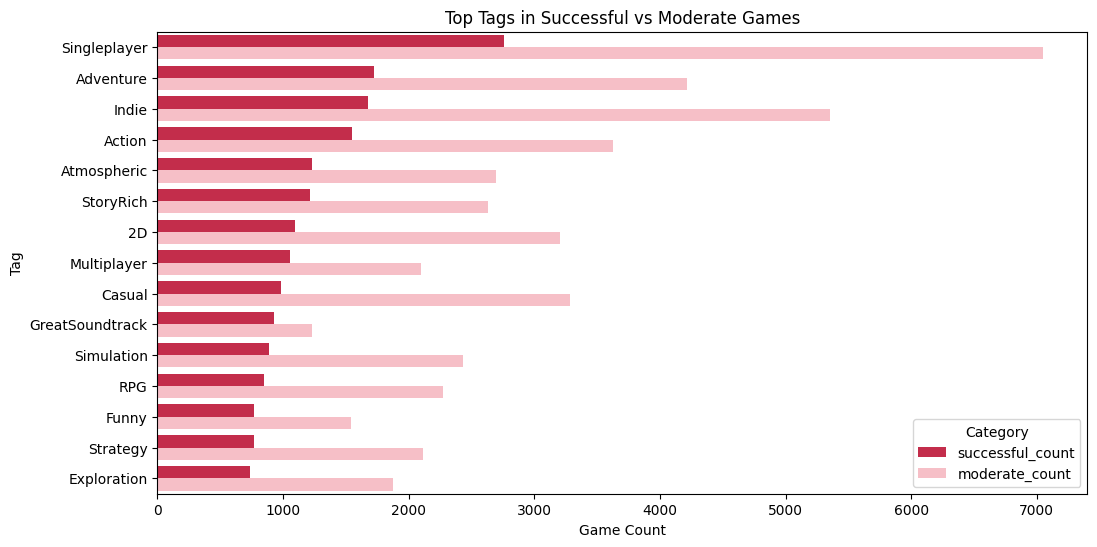

In [59]:
top_tags = most_used_tags_df.sort_values(by='successful_count', ascending=False).head(15)

melted_tags = top_tags.melt(id_vars="clean_tag", value_vars=["successful_count", "moderate_count"], 
                            var_name="Category", value_name="Count")

pink_palette = {
    "successful_count": "crimson",
    "moderate_count": "lightpink",    
}
plt.figure(figsize=(12, 6))
sns.barplot(data=melted_tags, x="Count", y="clean_tag", hue="Category", color='pink', palette=pink_palette)
plt.title("Top Tags in Successful vs Moderate Games")
plt.xlabel("Game Count")
plt.ylabel("Tag")
plt.show()